In [1]:
import local_models.local_models
import local_models.loggin
import local_models.TLS_models
import local_models.linear_projections
import local_models.utils
import local_models.algorithms
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import scipy.stats
import logging
import ml_battery.log
import time
import os
from IPython.display import Markdown as md
import joblib
import tqdm
import functools
import itertools

logger = logging.getLogger(__name__)

reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

def import_shit():
    import local_models.local_models
    import local_models.loggin
    import local_models.TLS_models
    import local_models.linear_projections
    import local_models.utils
    import local_models.algorithms
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.linear_model
    import sklearn.cluster
    from importlib import reload
    from ml_battery.utils import cmap
    import matplotlib as mpl
    import sklearn.datasets
    import scipy.stats
    import logging
    import ml_battery.log
    import time
    import os
    from IPython.display import Markdown as md
    import joblib
    import itertools
    import functools

In [2]:
def local_tls_shift_till_convergence(linear_models, data, tol=1e-8, 
                                     kernel=None,
                                     report=False):
    data = np.copy(data)
    unconverged = np.ones(data.shape[0], dtype=bool)
    while unconverged.any():
        tls_iterations = local_models.algorithms.local_tls_shift(linear_models, data[unconverged], iterations=1, kernel=kernel)
        old_data, data[unconverged] = next(tls_iterations), next(tls_iterations)
        distances_traveled = np.linalg.norm(data[unconverged] - old_data, axis=1)
        unconverged[unconverged] = distances_traveled > tol
        if report:
            yield data, scipy.stats.describe(distances_traveled)
        else:
            yield data

def local_mean_shift_till_convergence(mean_models, data, tol=1e-8,
                                     kernel=None,
                                     report=False):
    data = np.copy(data)
    unconverged = np.ones(data.shape[0], dtype=bool)
    while unconverged.any():
        tls_iterations = local_models.algorithms.mean_shift(mean_models, data[unconverged], iterations=1, kernel=kernel)
        old_data, data[unconverged] = next(tls_iterations), next(tls_iterations)
        distances_traveled = np.linalg.norm(data[unconverged] - old_data, axis=1)
        unconverged[unconverged] = distances_traveled > tol
        if report:
            yield data, scipy.stats.describe(distances_traveled)
        else:
            yield data

In [3]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
project_dir = "../data/moons_tls_shift_mean_shift"
os.makedirs(project_dir, exist_ok=1)

In [6]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

def noisy_moons_maker(n=None, noise=None, seed=None, bandwidth=None, kernel=local_models.local_models.TriCubeKernel):
    import_shit()
    NOISE_STEP=0.005
    noises = int(noise/NOISE_STEP)
    np.random.seed(seed)
    noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=0)
    for noise in range(noises): #so that we can move the same data a little bit at a time... i.e. noise 0.06 is only N(0,0.005) different than noise 0.055
        noisy_moons += np.random.normal(loc=0,scale=NOISE_STEP,size=(n,2))
    kernel_cb = kernel(bandwidth=bandwidth)
    modeler = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1))
    modeler.fit(noisy_moons)
    return noisy_moons, c, kernel_cb, modeler
     
def converge_and_plot_one(data_maker, grid, converger, report=False, **kwargs):
    import_shit()
    data, c, kernel_cb, modeler = data_maker(**kwargs)
    for dat in converger(modeler, grid, kernel=kernel_cb, report=report):
        pass
    return data, c, dat
  
def kwarg_namer(f, **kwargs):
    name = ""
    for key in sorted(kwargs):
        name += str(key) + ":"
        if isinstance(kwargs[key], float):
            name += "{:8.4f}".format(kwargs[key])
        elif isinstance(kwargs[key], int):
            name += "{:05d}".format(kwargs[key])
        else:
            name += str(kwargs[key])
        name += "_"
    return name, f(**kwargs)
        
def converge_and_plot_parallel(data_maker, grid, converger, jobs=32, report=False, **listified_kwargs):
    converged = joblib.Parallel(n_jobs=jobs)(
        joblib.delayed(functools.partial(kwarg_namer, functools.partial(
            converge_and_plot_one, data_maker, grid, converger, report=report)))(**kwargs)
        for kwargs in tqdm.tqdm(list(product_dict(**listified_kwargs))))
    return converged

    

In [7]:
np.random.seed(1)
noisy_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
KERNEL = local_models.local_models.GaussianKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(noisy_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

bandwidth = 0.3
n = 200

linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1))
linear_models.fit(noisy_moons)
mean_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(0))
mean_models.fit(noisy_moons)

In [8]:
for converged in local_tls_shift_till_convergence(linear_models, noisy_moons, kernel=KERNEL(bandwidth)):
    pass

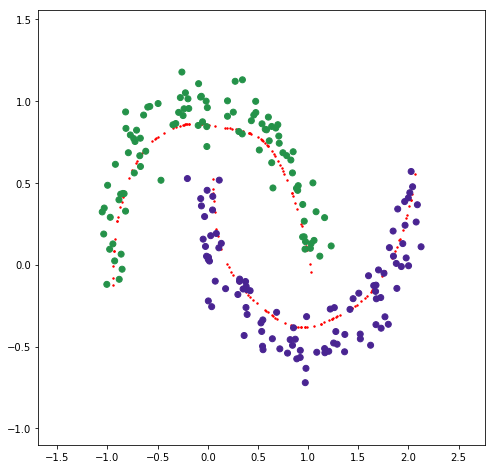

In [9]:
fig = plt.figure()
plt.scatter(converged[:,0], converged[:,1], c='r',s=2)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.xlim(*graph_bounds[:,0])
plt.ylim(*graph_bounds[:,1])
plt.savefig(os.path.join(project_dir, "{}.png".format("tls_shift")))

In [10]:
for meanshift_converged in local_tls_shift_till_convergence(mean_models, noisy_moons, kernel=KERNEL(bandwidth)):
    pass

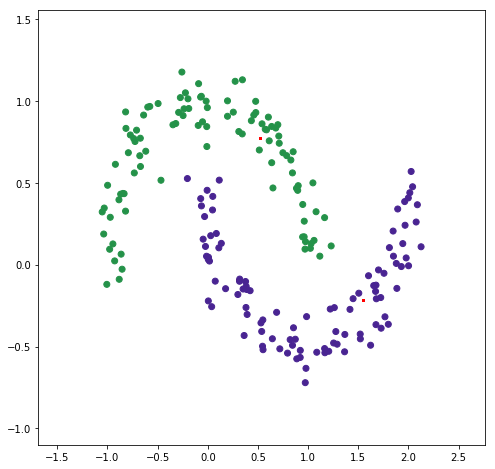

In [11]:
fig = plt.figure()
plt.scatter(meanshift_converged[:,0], meanshift_converged[:,1], c='r',s=2)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.xlim(*graph_bounds[:,0])
plt.ylim(*graph_bounds[:,1])
plt.savefig(os.path.join(project_dir, "{}.png".format("mean_shift")))

In [12]:
mean_models_converged = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(0))
mean_models_converged.fit(converged)

In [13]:
for tlsshift_meanshift_converged in local_tls_shift_till_convergence(mean_models_converged, converged, kernel=KERNEL(bandwidth)):
    pass

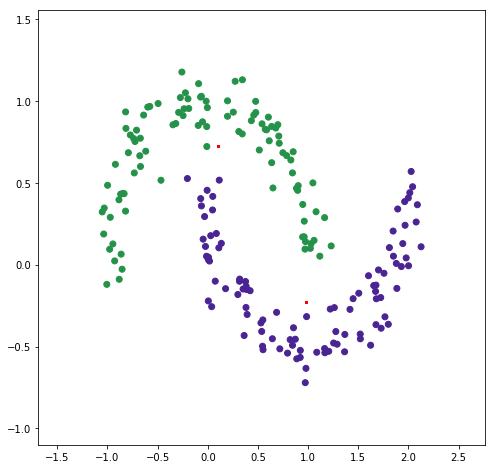

In [14]:
fig = plt.figure()
plt.scatter(tlsshift_meanshift_converged[:,0], tlsshift_meanshift_converged[:,1], c='r',s=2)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.xlim(*graph_bounds[:,0])
plt.ylim(*graph_bounds[:,1])
plt.savefig(os.path.join(project_dir, "{}.png".format("tls_mean_shift")))